# Objectives of this Lab
- understand the role of material "representations"

## Reminders
- activate your hsi25_ml-ssc_25.0 conda env (kernel)

# This time
- representing complex data (primarily molecules and materials)

In [1]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

plt.style.use('../files/plot_style.mplstyle')

In [2]:
from pymatgen.core.structure import Structure
from pymatgen.core.composition import Composition

from matminer.datasets import load_dataset
from matminer.featurizers.composition.composite import ElementProperty
from matminer.featurizers.composition.element import ElementFraction
from matminer.featurizers.structure.rdf import RadialDistributionFunction

# Representing crystal structures
- let's take a look at the "FLLA" dataset --> F. Faber, A. Lindmaa, O.A. von Lilienfeld, R. Armiento, “Crystal structure representations for machine learning models of formation energies”, Int. J. Quantum Chem. 115 (2015) 1094–1101. doi:10.1002/qua.24917
- ~4000 inorganic materials
- ground-truth is plane wave density functional theory
- goal is for our ML model to be a surrogate for DFT by giving us a fast estimate of the formation energy (used as input to thermodynamic models)

In [3]:
df = load_dataset('flla')
del df['formula']

def get_formula(row):
    s = row['structure']
    formula = s.formula
    reduced_formula = Composition(formula).reduced_formula
    return reduced_formula

df['formula'] = df.apply(get_formula, axis=1)

df.head()

/Users/cbartel/bin/anaconda3/envs/hsi25_ml-ssc_25.0/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:120: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/Users/cbartel/bin/anaconda3/envs/hsi25_ml-ssc_25.0/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:120: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


,material_id,e_above_hull,nsites,structure,formation_energy,formation_energy_per_atom,formula
0,mp-10,0.107405,2,"[[1.11758409 0.79025129 1.93571242] As, [3.352...",0.214810,0.107405,As
1,mp-10000,0.000000,6,"[[0. 0. 8.84051822] S, [0. ...",-7.520110,-1.253352,Hf2S
2,mp-10004,0.000000,16,"[[1.62101142 2.03208456 2.71687137] P, [2.9549...",-5.429887,-0.339368,Mo3P
3,mp-10010,0.000000,5,"[[0. 0. 0.] Al, [-2.29850896e-08 2.26918935e+...",-2.684175,-0.536835,Al(CoSi)2
4,mp-10021,0.004781,2,"[[2.39728273 0.77565449 2.62420188] Ga, [0.393...",0.009563,0.004781,Ga


# First, we'll get a fingerprint that just captures the chemical composition

In [4]:
def get_elfrac_composition_vector(row):
    return ElementFraction().featurize(Composition(row['formula']))

df['elfrac_vector'] = df.apply(get_elfrac_composition_vector, axis=1)

df.head()

,material_id,e_above_hull,nsites,structure,formation_energy,formation_energy_per_atom,formula,elfrac_vector
0,mp-10,0.107405,2,"[[1.11758409 0.79025129 1.93571242] As, [3.352...",0.214810,0.107405,As,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,mp-10000,0.000000,6,"[[0. 0. 8.84051822] S, [0. ...",-7.520110,-1.253352,Hf2S,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,mp-10004,0.000000,16,"[[1.62101142 2.03208456 2.71687137] P, [2.9549...",-5.429887,-0.339368,Mo3P,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2..."
3,mp-10010,0.000000,5,"[[0. 0. 0.] Al, [-2.29850896e-08 2.26918935e+...",-2.684175,-0.536835,Al(CoSi)2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.4,..."
4,mp-10021,0.004781,2,"[[2.39728273 0.77565449 2.62420188] Ga, [0.393...",0.009563,0.004781,Ga,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
LiCl_elfrac = df.elfrac_vector.get(df.formula == 'LiCl').values

In [6]:
LiCl_elfrac

array([list([0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
      dtype=object)

# Now, we'll get a fingerprint that captures elemental **properties**
- converting chemical formulas into vectors using things like average electronegativity, average radius, etc.

In [7]:
elprop = ElementProperty.from_preset('matminer')
elprop

ElementProperty(data_source=<matminer.utils.data.PymatgenData object at 0x17717f5d0>,
                features=['X', 'row', 'group', 'block', 'atomic_mass',
                          'atomic_radius', 'mendeleev_no',
                          'electrical_resistivity', 'velocity_of_sound',
                          'thermal_conductivity', 'melting_point',
                          'bulk_modulus',
                          'coefficient_of_linear_thermal_expansion'],
                stats=['minimum', 'maximum', 'range', 'mean', 'std_dev'])

In [8]:
our_props = ElementProperty(data_source='pymatgen', features=['X', 'mendeleev_no', 'atomic_radius', 'melting_point'], stats=['mean', 'std_dev'])
our_props

ElementProperty(data_source=<matminer.utils.data.PymatgenData object at 0x177171710>,
                features=['X', 'mendeleev_no', 'atomic_radius',
                          'melting_point'],
                stats=['mean', 'std_dev'])

## Let's look at a random formula in our dataset

In [9]:
some_formula = df.formula.values[21]
print(some_formula)

LiZnP


## Now convert that formula to our "element property" vector

In [10]:
our_props.featurize(Composition(some_formula))

[1.6066666666666667,
 0.6061627944152737,
 59.333333333333336,
 41.58525379666852,
 1.2666666666666666,
 0.23629078131263043,
 487.88999999999993,
 190.012541954472]

## What do those values correspond with?

In [11]:
def get_features_and_values(formula):
    feature_values = our_props.featurize(Composition(formula))
    feature_labels = our_props.feature_labels()
    labels_to_values = dict(zip(feature_labels, feature_values))
    labels_to_values = {k.strip('PymatgenData').replace(' ', '_')[1:] : v for i, (k, v) in enumerate(labels_to_values.items()) if v}
    return labels_to_values

In [12]:
get_features_and_values(some_formula)

{'mean_X': 1.6066666666666667,
 'std_dev_X': 0.6061627944152737,
 'mean_mendeleev_no': 59.333333333333336,
 'std_dev_mendeleev_no': 41.58525379666852,
 'mean_atomic_radius': 1.2666666666666666,
 'std_dev_atomic_radius': 0.23629078131263043,
 'mean_melting_poi': 487.88999999999993,
 'std_dev_melting_poi': 190.012541954472}

## Let's apply this to our whole dataset

In [13]:
def get_matminer_composition_vector(row):    
    elprop = our_props
    formula = row['formula']
    return elprop.featurize(Composition(formula))

df['matminer_vector'] = df.apply(get_matminer_composition_vector, axis=1)

/Users/cbartel/bin/anaconda3/envs/hsi25_ml-ssc_25.0/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:120: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/Users/cbartel/bin/anaconda3/envs/hsi25_ml-ssc_25.0/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:120: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


In [14]:
df.head()

,material_id,e_above_hull,nsites,structure,formation_energy,formation_energy_per_atom,formula,elfrac_vector,matminer_vector
0,mp-10,0.107405,2,"[[1.11758409 0.79025129 1.93571242] As, [3.352...",0.214810,0.107405,As,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.18, 0, 89.0, 0, 1.15, 0, 1090.0, 0]"
1,mp-10000,0.000000,6,"[[0. 0. 8.84051822] S, [0. ...",-7.520110,-1.253352,Hf2S,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.7266666666666666, 0.9050966799187808, 64.66..."
2,mp-10004,0.000000,16,"[[1.62101142 2.03208456 2.71687137] P, [2.9549...",-5.429887,-0.339368,Mo3P,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2...","[2.1675, 0.021213203435596288, 64.5, 24.041630..."
3,mp-10010,0.000000,5,"[[0. 0. 0.] Al, [-2.29850896e-08 2.26918935e+...",-2.684175,-0.536835,Al(CoSi)2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.4,...","[1.834, 0.1404457190518813, 75.6, 12.057155551..."
4,mp-10021,0.004781,2,"[[2.39728273 0.77565449 2.62420188] Ga, [0.393...",0.009563,0.004781,Ga,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.81, 0, 81.0, 0, 1.3, 0, 302.91, 0]"


# Let's compare the two fingerprints

In [15]:
formula = 'NaMnSe2'

elfrac_vector = df['elfrac_vector'].get(df.formula == formula).values[0]
matminer_vector = df['matminer_vector'].get(df.formula == formula).values[0]

print('elfrac_vector has %i features' % len(elfrac_vector))
print('matminer_vector has %i features' % len(matminer_vector))

elfrac_vector has 103 features
matminer_vector has 8 features


/Users/cbartel/bin/anaconda3/envs/hsi25_ml-ssc_25.0/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


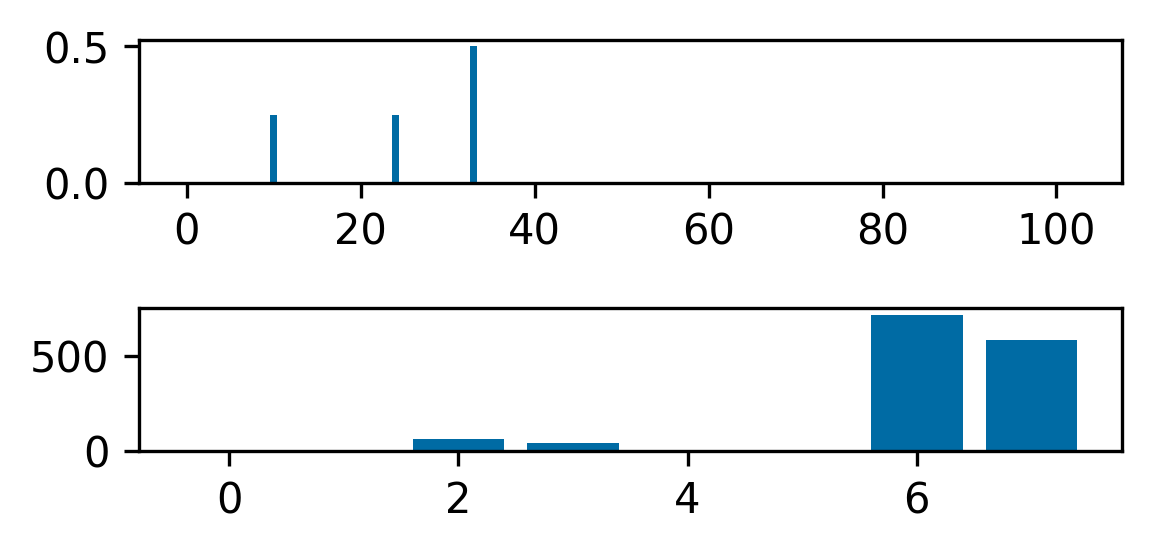

In [16]:
fig = plt.figure()
ax1 = plt.subplot(211)
ax1 = plt.bar(list(range(len(elfrac_vector))), elfrac_vector)
ax2 = plt.subplot(212)
ax2 = plt.bar(list(range(len(matminer_vector))), matminer_vector)

# Now we could train models with each. Which one do you think should work better?
- we'll write a quick function to run CV with these models

In [18]:
def CV(feature):
    # convert our single column containing all features into a feature matrix (each item of the vector becomes a column of the matrix)
    X = np.vstack(df[feature].values)

    # grab our target
    y = df['formation_energy_per_atom'].values

    # split our data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=44)

    # use mean imputation (to fill in NaNs)
    imputer = SimpleImputer(strategy='mean')    

    # initialize a vanilla random forest
    rf = RandomForestRegressor()

    # impute --> fit
    pipe = Pipeline([('impute', imputer), ('rf', rf)])

    # run three-fold CV
    scores = cross_validate(pipe, X_train, y_train, cv=3, return_train_score=True, scoring='neg_root_mean_squared_error')
    print('Training score = %.3f +/- %.4f' % (np.mean(abs(scores['train_score'])), np.std(abs(scores['train_score']))))
    print('Validation score = %.3f +/- %.4f' % (np.mean(abs(scores['test_score'])), np.std(abs(scores['test_score']))))

    # re-train model on full training set (to inspect importances)
    pipe.fit(X_train, y_train)

    # return scores and the model fit to the full training set
    return scores, pipe['rf']

# Now, we'll compare the featurization based on element fraction and based on the element properties

In [19]:
for feature in ['elfrac_vector', 'matminer_vector']:
    print('~~~~ %s ~~~~' % feature)
    scores, rf = CV(feature)
    print('\n')

~~~~ elfrac_vector ~~~~
Training score = 0.161 +/- 0.0059
Validation score = 0.408 +/- 0.0234


~~~~ matminer_vector ~~~~
Training score = 0.155 +/- 0.0043
Validation score = 0.384 +/- 0.0204




### With ~10x fewer features, the element property (matminer vector) does better!

# Let's see which features are most important
- the default built-in `feature_importances_` applies average impurity decrease to rank feature importances

In [20]:
importances = rf.feature_importances_
importances

array([0.07321922, 0.71505383, 0.01979537, 0.02882762, 0.05812186,
       0.02570554, 0.04288579, 0.03639078])

In [21]:
def plot_importances(features_and_their_importances, ylabel='average impurity decrease', n_features_to_plot=10, figsize=(7,5)):
    """
    Args:
        features_and_their_importances (dict):
            {feature (str) : importance (float)}
    Returns:
        matplotlib bar chart of sorted importances
    """
    axis_width = 1.5
    maj_tick_len = 6
    fontsize = 14
    bar_color = 'lightblue'
    align = 'center'
    label = '__nolegend__'
    
    sorted_features = sorted(features_and_their_importances, 
                             key=features_and_their_importances.get, 
                             reverse=True)
    sorted_importances = [features_and_their_importances[f] for f in sorted_features]

    if len(sorted_features) < n_features_to_plot:
        n_features_to_plot = len(sorted_features)

    fig = plt.figure(figsize=figsize)
    ax = plt.bar(range(n_features_to_plot), sorted_importances[:n_features_to_plot],
                 color=bar_color, align=align, label=label)
    ax = plt.xticks(range(n_features_to_plot), sorted_features[:n_features_to_plot], rotation=90)
    ax = plt.xlim([-1, n_features_to_plot])
    ax = plt.ylabel(ylabel, fontsize=fontsize)
    ax = plt.tick_params('both', length=maj_tick_len, width=axis_width, 
                         which='major', right=True, top=True)
    ax = plt.xticks(fontsize=fontsize)
    ax = plt.yticks(fontsize=fontsize)
    ax = plt.tight_layout()
    return ax

/Users/cbartel/bin/anaconda3/envs/hsi25_ml-ssc_25.0/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


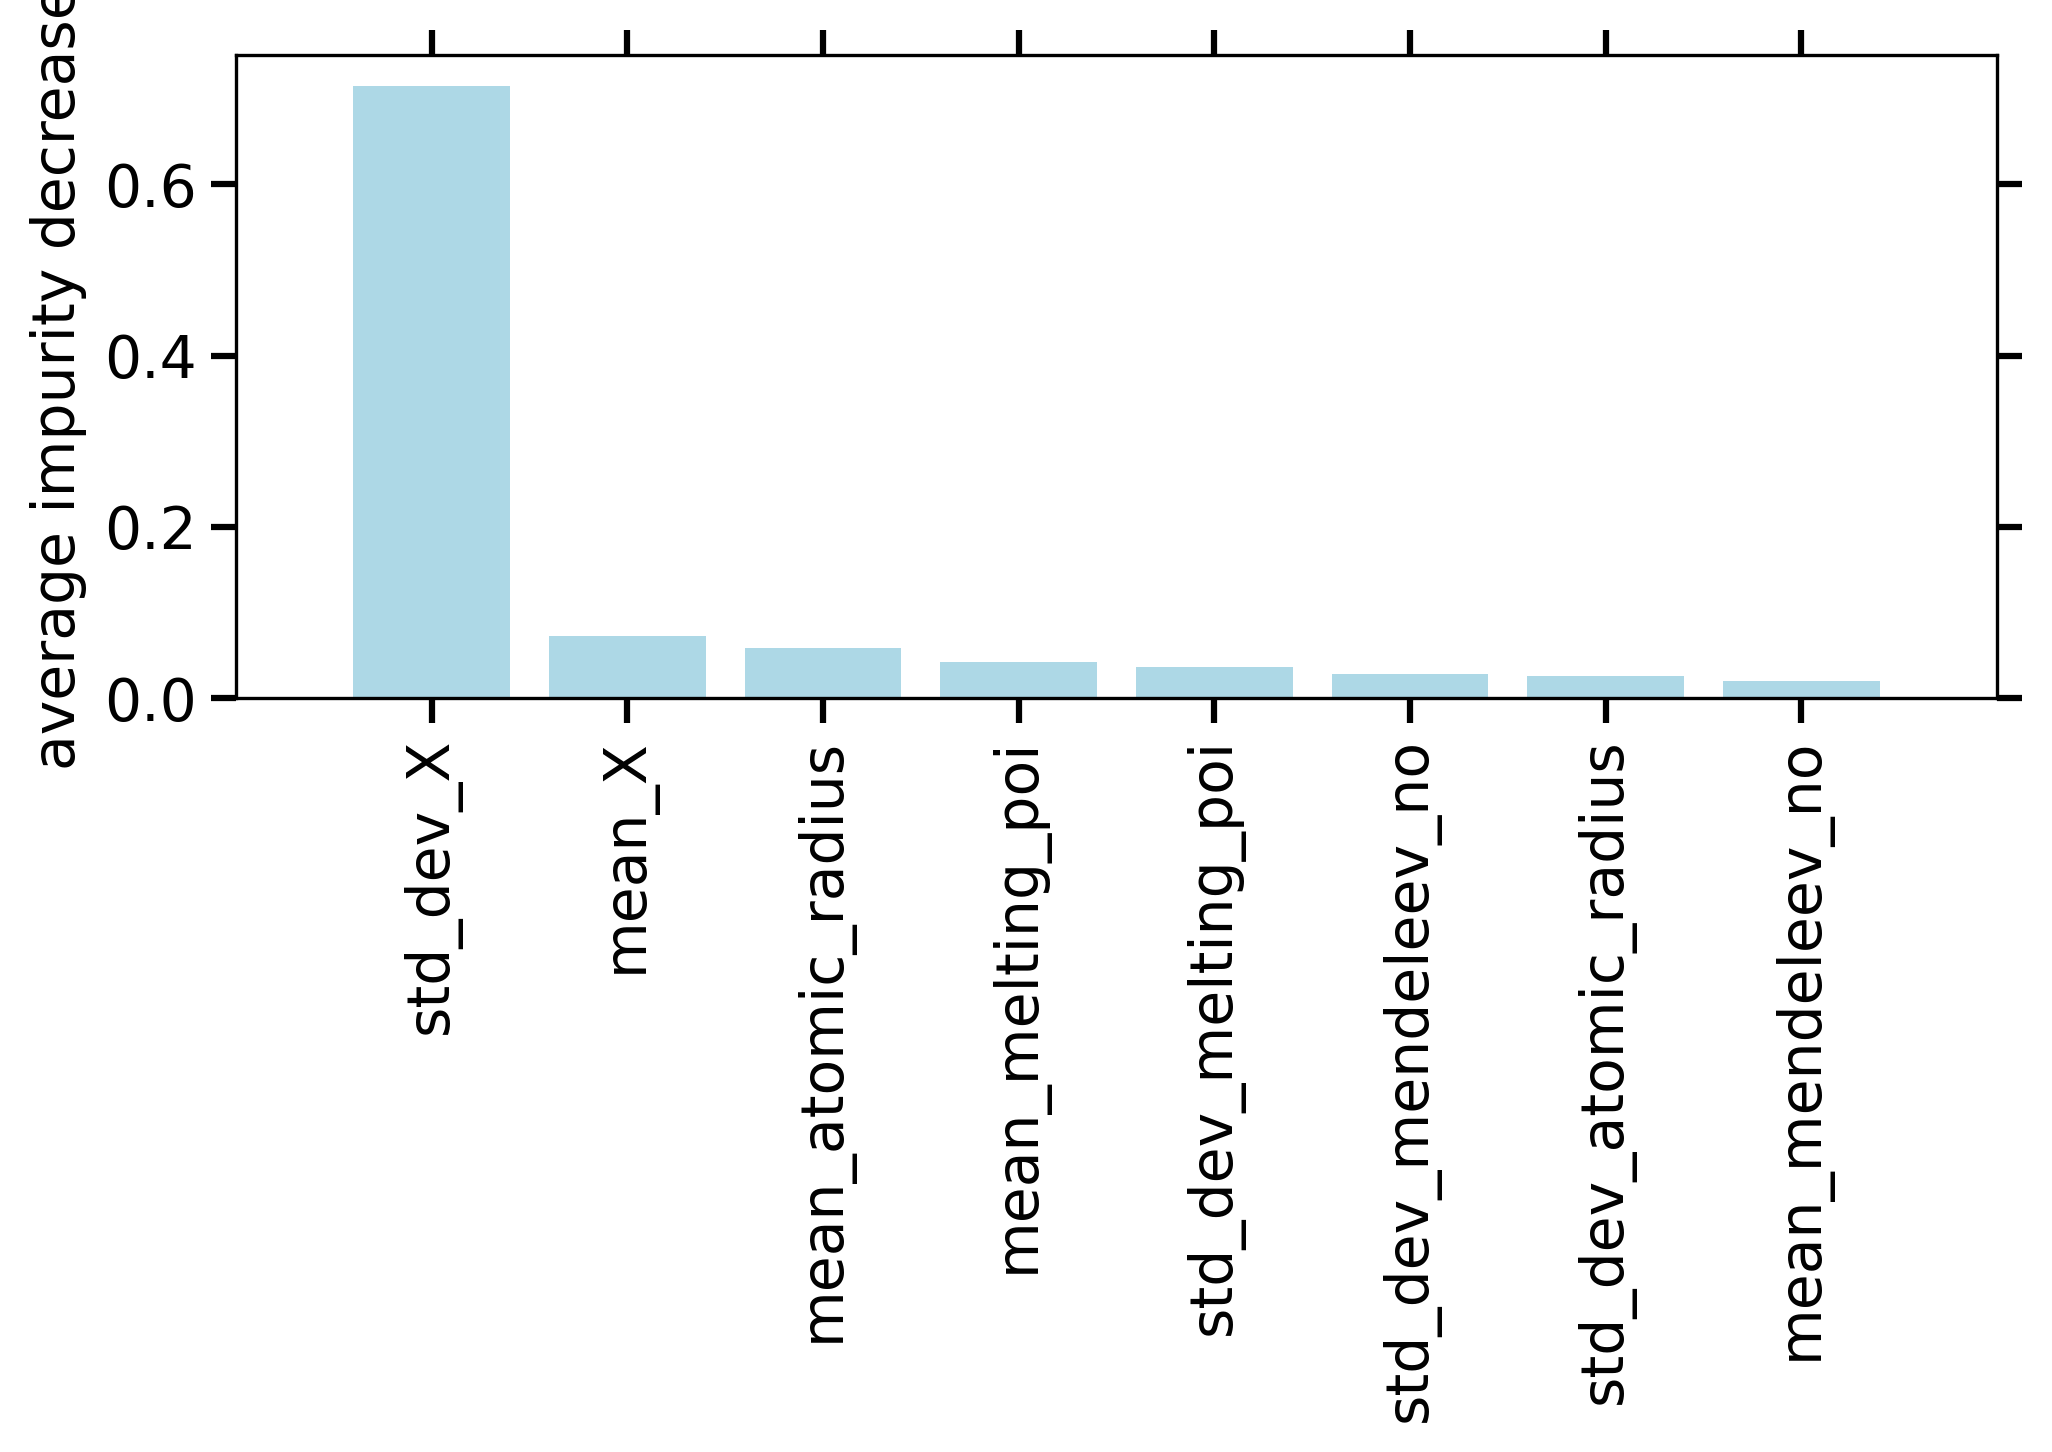

In [22]:
feature_labels = list(get_features_and_values(formula).keys())
features_and_their_importances = dict(zip(feature_labels, importances))
plot_importances(features_and_their_importances)

## Let's compare to the element fraction features

In [23]:
scores, rf = CV('elfrac_vector')

Training score = 0.159 +/- 0.0058
Validation score = 0.408 +/- 0.0229


/Users/cbartel/bin/anaconda3/envs/hsi25_ml-ssc_25.0/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


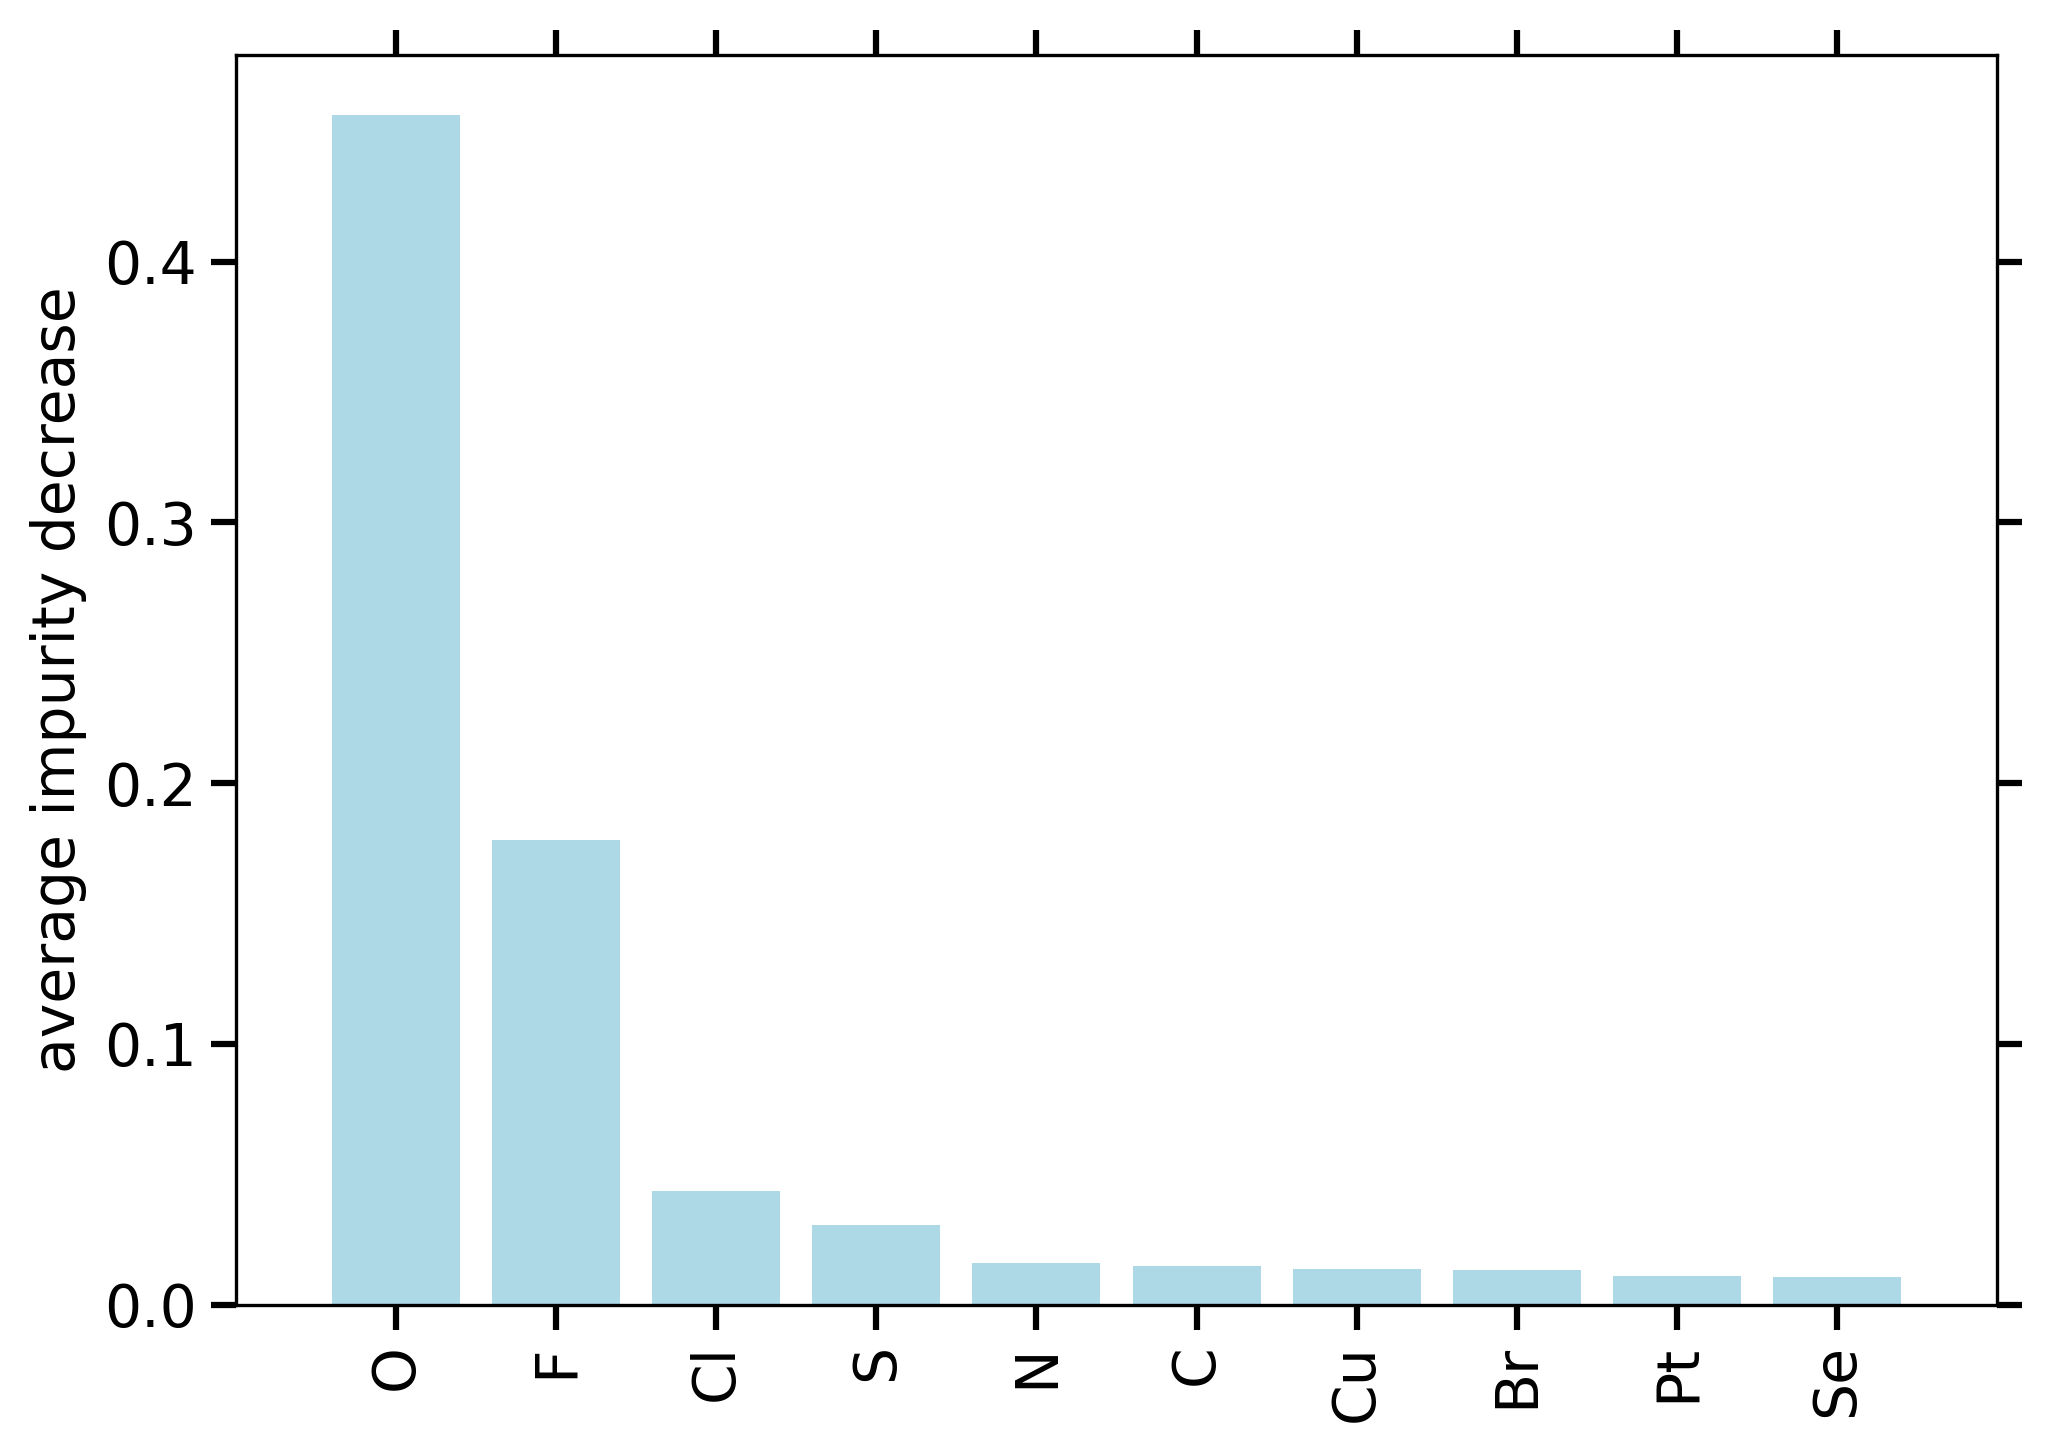

In [24]:
importances = rf.feature_importances_
feature_labels = ElementFraction().feature_labels()
features_and_their_importances = dict(zip(feature_labels, importances))
plot_importances(features_and_their_importances)

# How does this compare to published models for formation energy?
- Here is the state of the art for a similar prediction task using only chemical composition (from [this paper](https://www.nature.com/articles/s41467-020-19964-7))
![](../files/roost.png)



## What if we also know the crystal structure?
- from [this paper](https://www.nature.com/articles/s41586-023-06735-9)

![](../files/gnome.png)

# Let's look at a crystal structure file

In [25]:
random_index = 3935

structure = df['structure'].values[random_index]

print(structure)

Full Formula (Mn8 N4)
Reduced Formula: Mn2N
abc   :   4.397323   4.826919   5.547829
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (12)
  #  SP           a         b         c    coordination_no  forces
---  ----  --------  --------  --------  -----------------  --------------------------------------
  0  N     0.5       0.75      0.13381                   6  [0.0, 0.0, -0.00139824]
  1  N     0         0.25      0.36619                   6  [0.0, 0.0, 0.00139824]
  2  N     0.5       0.25      0.86619                   6  [0.0, 0.0, 0.00139824]
  3  N     0         0.75      0.63381                   6  [0.0, 0.0, -0.00139824]
  4  Mn    0.250086  0.082902  0.120991                  6  [-0.00013816, -7.103e-05, -0.00040163]
  5  Mn    0.750086  0.917098  0.379009                  6  [-0.00013816, 7.103e-05, 0.00040163]
  6  Mn    0.249914  0.582902  0.379009                  6  [0.00013816, -7.103e-05, 0.00040163]
  7  Mn    0.749914  0.417098

# Featurizing crystal structures introduces new challenges:
- how do we create "fixed-length" vectors to feed to ML models?
- how do we handle "invariances" (eg wrt to supercell expansions)?
- how do we encode chemical identities in addition to atomic positions?

# Let's explore one approach to featurizing structure
- the radial distribution function
- here, our features will simply be a binned histogram of distances (r) and the values for each feature will be g(r)

## This will nicely handle "fixed-length" problem and supercell invariances

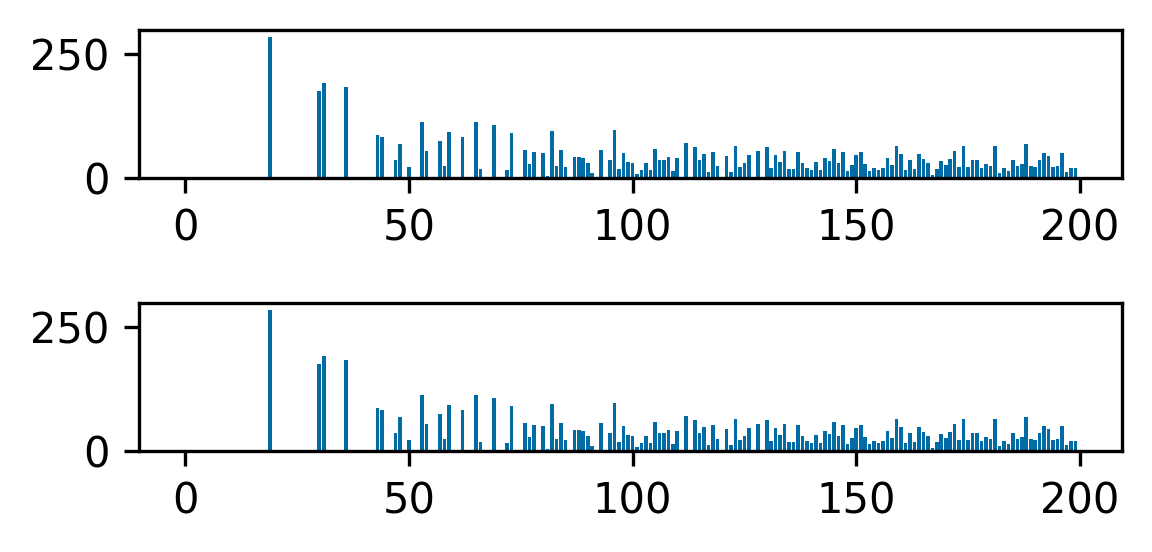

In [26]:
rdf = RadialDistributionFunction()
unitcell = df.structure.get(df.formula == 'AlN').values[0]
supercell = unitcell.make_supercell(2,2,2)

unit_rdf = rdf.featurize(unitcell)
super_rdf = rdf.featurize(supercell)

fig = plt.figure()
ax = plt.subplot(211)
ax = plt.bar(list(range(len(unit_rdf))), unit_rdf)
ax = plt.subplot(212)
ax = plt.bar(list(range(len(super_rdf))), super_rdf)

## Let's compare our three "fingerprints"

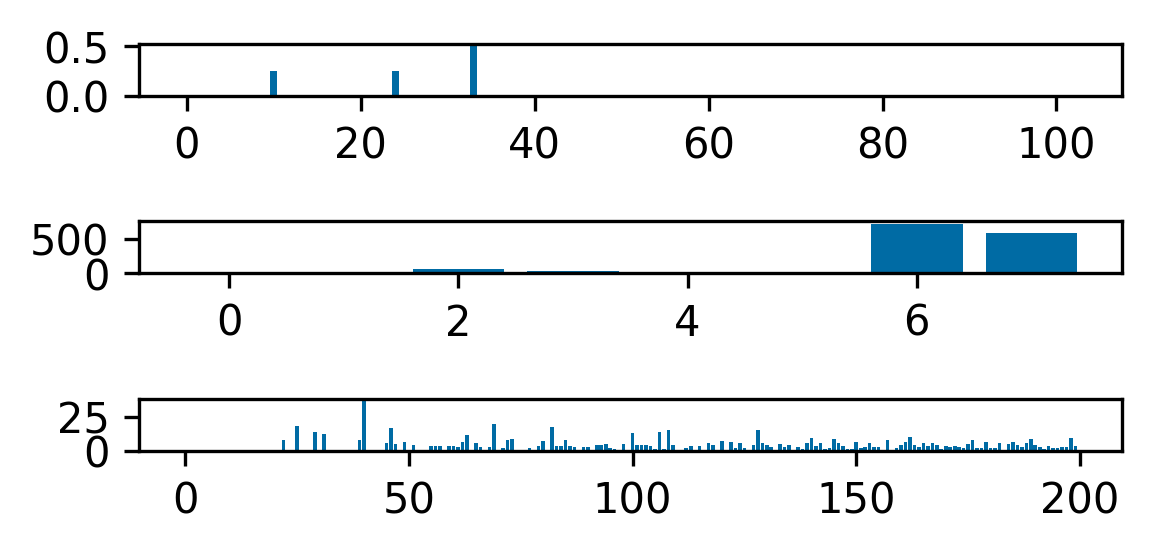

In [27]:
formula = 'NaMnSe2'
elfrac_vector = df['elfrac_vector'].get(df.formula == formula).values[0]
matminer_vector = df['matminer_vector'].get(df.formula == formula).values[0]
rdf_vector = rdf.featurize(df['structure'].get(df.formula == formula).values[0])

fig = plt.figure()
ax1 = plt.subplot(311)
ax1 = plt.bar(list(range(len(elfrac_vector))), elfrac_vector)
ax2 = plt.subplot(312)
ax2 = plt.bar(list(range(len(matminer_vector))), matminer_vector)
ax3 = plt.subplot(313)
ax3 = plt.bar(list(range(len(rdf_vector))), rdf_vector)


## Let's apply the rdf vector to all materials (this may take a minute)

In [28]:
structures = df.structure.values
rdfs = [rdf.featurize(s) for s in structures]
df['rdf_vector'] = rdfs

# A common way to understand representations is through "similarities"
- cosine similarity --> popular for high-dimensional representations (vectors)
- Euclidean similarity --> more amenable to low-dimensional representations (common "distance")

In [29]:
def similarity(a, b, method='cosine'):
    """
    Args:
        a (np.array) : a feature vector for a material
        b (np.array) : a feature vector for another material
        method (str) : "cosine" or "euclidean"

    Returns:
        if method == 'cosine':
            the cosine similarity (1 - the cosine distance between the two vectors) (float)
        if method == 'euclidean':
            the inverse Euclidean distance (float)
    """    
    a = np.nan_to_num(a)
    b = np.nan_to_num(b)
    if method == 'cosine':
        return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    elif method == 'euclidean':
        dist = np.linalg.norm(a-b)
        if dist != 0:
            return 1/dist
        else:
            return 1e6
    else:
        raise NotImplementedError

## Group activities
**Guidelines**
- Find the 5 materials in your dataset that are most similar to aluminum nitride (AlN).
- Consider the choice of representation. Does it matter?

In [31]:
###### STUDENTS CODE HERE
def get_similarities(base_compound='AlN', feature='elfrac_vector', method='cosine'):
    base_vector = df[feature].get(df.formula == base_compound).values[0]
    all_vectors = df[feature].values
    all_formulas = df['formula'].values
    all_similarities = [similarity(base_vector, v, method=method) for v in all_vectors]
    sorted_indices = np.argsort(all_similarities)[::-1]
    top_6 = all_formulas[sorted_indices[:6]]
    print('The most similar formulas to %s are %s' % (base_compound, top_6))
    return dict(zip(all_formulas, all_similarities))

In [32]:
sims = get_similarities(base_compound='AlN', feature='elfrac_vector', method='cosine')
sims = get_similarities(base_compound='AlN', feature='matminer_vector', method='cosine')
sims = get_similarities(base_compound='AlN', feature='rdf_vector', method='cosine')

The most similar formulas to AlN are ['AlN' 'N2' 'Al' 'CaN6' 'Al6Fe' 'K2CdN12']
The most similar formulas to AlN are ['AlN' 'AlO' 'CoSb2Br2O3' 'Ag2HgO2' 'MgCl2' 'MgCl2']
The most similar formulas to AlN are ['AlN' 'Ba2TaN3' 'KLi6TaO6' 'Li6CoO4' 'MnV2TeO7' 'KLi6IrO6']


## Let's fit some models using the rdf vector

In [33]:
scores, rf = CV('rdf_vector')


Training score = 0.317 +/- 0.0021
Validation score = 0.851 +/- 0.0058


/Users/cbartel/bin/anaconda3/envs/hsi25_ml-ssc_25.0/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


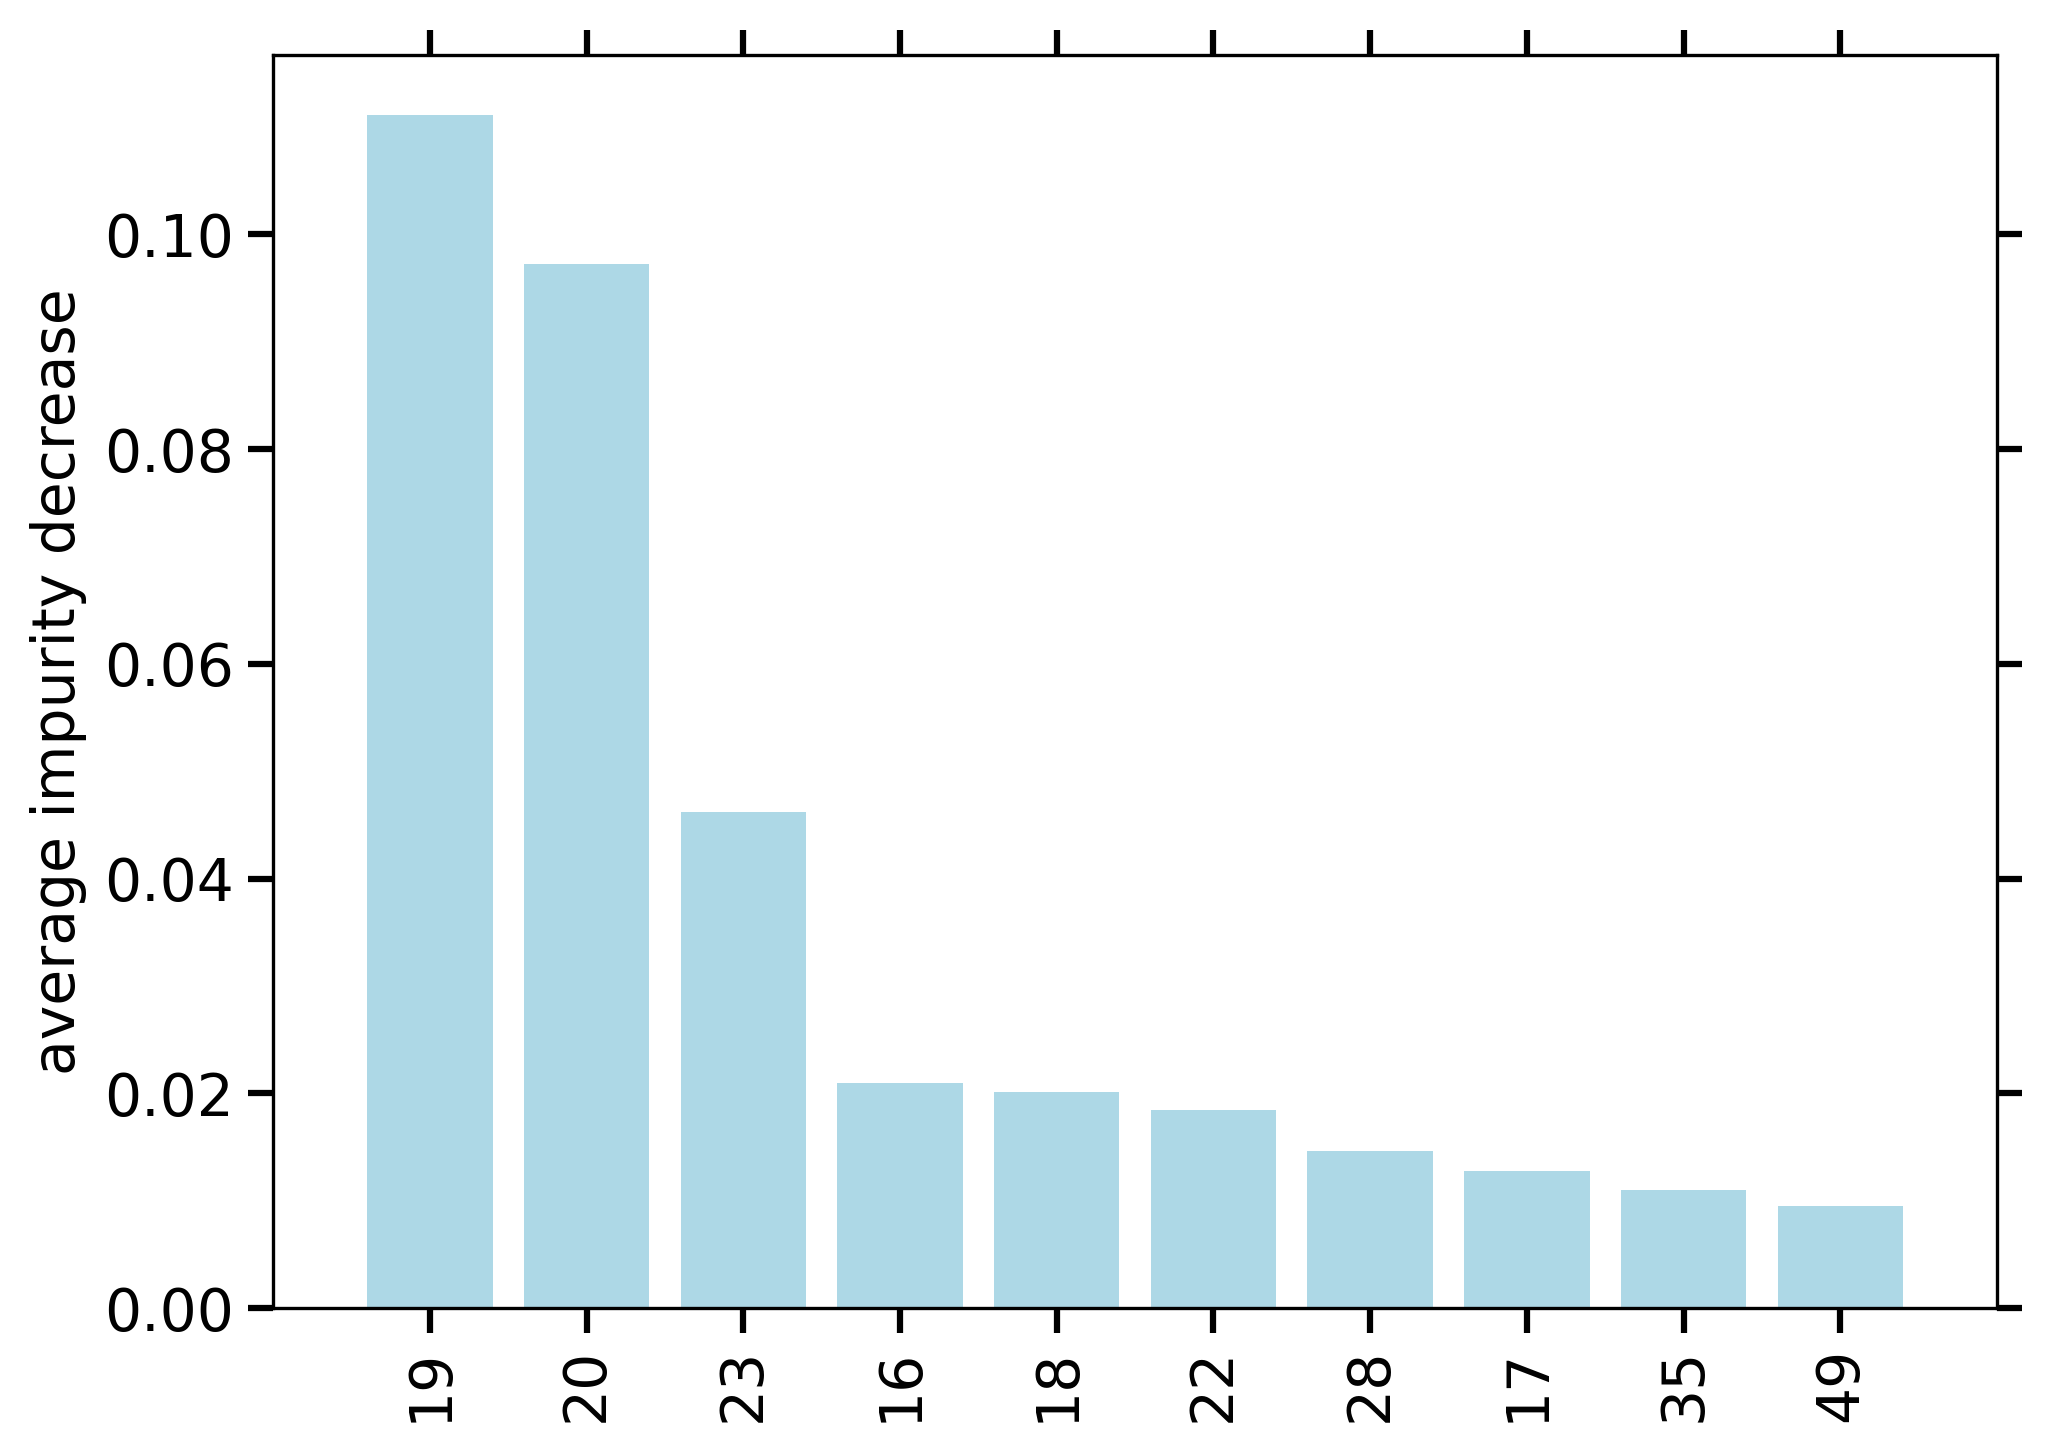

In [34]:
importances = rf.feature_importances_
feature_labels = list(range(len(importances)))
features_and_their_importances = dict(zip(feature_labels, importances))
plot_importances(features_and_their_importances, n_features_to_plot=10)

# More processing (and probably data!) required.. and algorithm matters! 
- Kernel ridge regression is popular with these fingerprint-like features
  - read more about KRR [here](https://dmol.pub/ml/kernel.html) and [here](https://github.com/fullmetalfelix/ML-CSC-tutorial/blob/master/krr_homo.ipynb) (among many other places)
- also more approaches that are especially amenable to kernel-based methods (e.g., see [SOAP](https://singroup.github.io/dscribe/0.3.x/tutorials/soap.html)) and many more that are amenable to deep learning (e.g., [equivariant neural networks](https://github.com/mir-group/nequip))